In [1]:
import os
import cv2 
import json
import matplotlib.pyplot as plt
from scipy import ndimage
import math
from tqdm.notebook import tqdm

import os
import numpy as np
import random
import torch
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.autograd import Variable

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
TIFF_PATH = "/media/andrey/big/datasets/hacksAI/TaskMFTI/train/original.tiff"
TRAIN_PATH = "/media/andrey/big/datasets/hacksAI/TaskMFTI/train/train"
TEST_PATH = "/media/andrey/big/datasets/hacksAI/TaskMFTI/test"
TRAIN_IMG_PATH = os.path.join(TRAIN_PATH, "img")
TRAIN_JSON_PATH = os.path.join(TRAIN_PATH, "json")

(10496, 10496, 3)


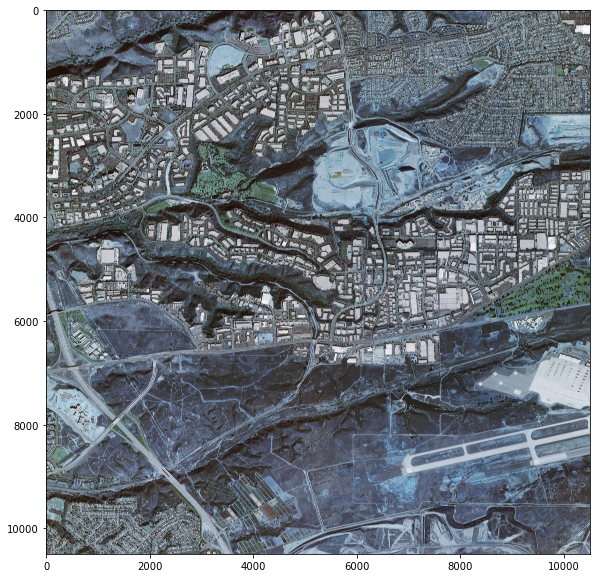

In [4]:
FULL_TIFF = cv2.imread(TIFF_PATH)
print(FULL_TIFF.shape)
plt.imshow(FULL_TIFF)

In [9]:
sum_matrix = np.zeros((10496, 10496, 3))
count_matrix = np.zeros((10496, 10496))

files = sorted(os.listdir(TRAIN_JSON_PATH), key=lambda x: int(x.split(".")[0]))
for name in tqdm(files[:528]):
    with open(os.path.join(TRAIN_JSON_PATH, name)) as file:
        example_json = json.load(file)
    
    pt_A = [0, 0]
    pt_B = [0, 1024]
    pt_C = [1024, 1024]
    pt_D = [1024, 0]

    img = cv2.imread(os.path.join(TRAIN_IMG_PATH, name.split(".")[0] + ".png"))
    input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
    output_pts = np.float32([example_json["left_top"],
                            example_json["left_bottom"],
                            example_json["right_bottom"],
                            example_json["right_top"]])

    M = cv2.getPerspectiveTransform(input_pts,output_pts)
    out = cv2.warpPerspective(img,M,(10496, 10496),flags=cv2.INTER_LINEAR)
    sum_matrix += out
    count_matrix += out.astype(np.int32).sum(axis=-1) > 0

  0%|          | 0/528 [00:00<?, ?it/s]

In [10]:
matrix = (sum_matrix + 1e-5) / (count_matrix[:, :, np.newaxis] + 1e-5)

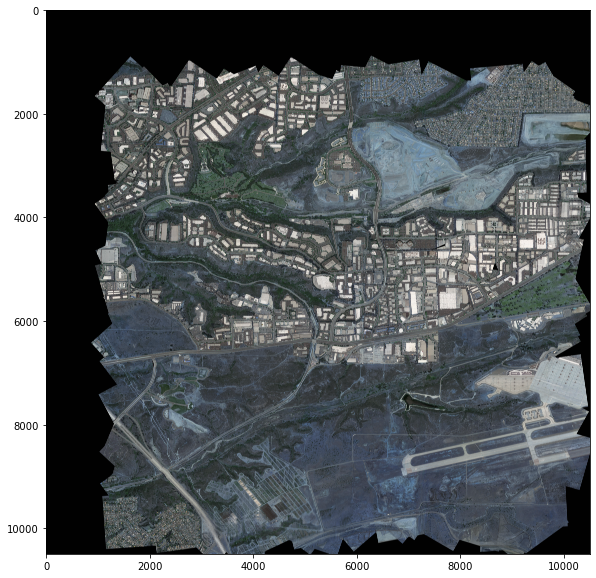

In [11]:
plt.imshow(matrix.astype(np.uint8))

In [12]:
matrix_bgr = matrix.astype(np.uint8)

In [13]:
MATRIX_RESIZED = cv2.resize(matrix_bgr, (2624, 2624))

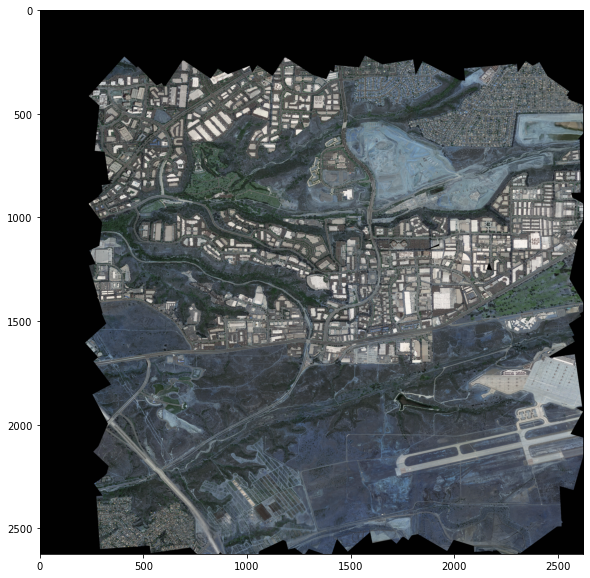

In [14]:
plt.imshow(MATRIX_RESIZED)

In [165]:
MEAN = np.array([[[0.485, 0.456, 0.406]]])
STD = np.array([[[0.229, 0.224, 0.225]]])

def rotate_and_crop(img, angle):
    img_rotated = ndimage.rotate(img, angle)
    slice_x = int((img_rotated.shape[1] - 128) / 2.)
    slice_y = int((img_rotated.shape[0] - 128) / 2.)
    img_rotated = img_rotated[slice_y:slice_y + 128, slice_x:slice_x + 128]
    
    #slice_x = int((img_rotated.shape[1] - 256) / 2.)
    #slice_y = int((img_rotated.shape[0] - 256) / 2.)
    #img_rotated = img_rotated[slice_y:slice_y + 256, slice_x:slice_x + 256]
    return img_rotated

def norm_img(img):
    return (img - img.mean()) / (img.std() + 1e-8)
    #img = img / 256.
    #return (img - MEAN) / STD

In [196]:
MATRIX_RESIZED_CUDA = torch.from_numpy(MATRIX_RESIZED).cuda().float()

In [201]:
VAL_NAMES = [name for name in os.listdir(TEST_PATH)]

In [202]:
VAL_IMAGES = []
for name in tqdm(VAL_NAMES):
    image_path = os.path.join(TEST_PATH, name)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256))
    VAL_IMAGES.append(img)

  0%|          | 0/400 [00:00<?, ?it/s]

In [203]:
SIZE = len(VAL_IMAGES)
scores_all = 10000 * np.ones((SIZE,))
angles_best = np.zeros((SIZE,))
x_best = np.zeros((SIZE,))
y_best = np.zeros((SIZE,))

for angle in range(0, 360):
    print("Process angle:", angle)
    
    batched_images = []
    for img in tqdm(VAL_IMAGES):
        img = rotate_and_crop(img, angle)
        img = (img - img.mean()) / (img.std() + 1e-8)
        batched_images.append(img)
    batched_images = torch.from_numpy(np.array(batched_images)).cuda().float()
    
    for y in tqdm(range(64, 2624 - 64, 8)):
        for x in range(64, 2624 - 64, 8):
            tiff = MATRIX_RESIZED_CUDA[y -64:y + 64, x -64 :x + 64]
            tiff = (tiff - tiff.mean()) / (tiff.std() + 1e-8)

            scores = (tiff.unsqueeze(0) - batched_images).std(dim=(-2, -3)).mean(dim=-1).cpu().numpy()
            mask = scores_all > scores
            scores_all[mask] = scores[mask]
            angles_best[mask] = angle
            x_best[mask] = x
            y_best[mask] = y

Process angle: 0


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 1


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 2


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 3


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 4


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 5


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 6


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 7


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 8


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 9


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 10


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 11


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 12


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 13


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 14


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 15


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 16


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 17


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 18


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 19


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 20


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 21


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 22


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 23


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 24


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 25


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 26


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 27


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 28


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 29


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 30


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 31


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 32


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 33


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 34


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 35


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 36


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 37


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 38


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 39


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 40


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 41


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 42


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 43


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 44


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 45


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 46


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 47


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 48


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 49


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 50


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 51


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 52


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 53


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 54


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 55


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 56


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 57


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 58


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 59


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 60


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 61


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 62


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 63


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 64


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 65


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 66


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 67


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 68


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 69


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 70


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 71


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 72


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 73


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 74


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 75


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 76


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 77


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 78


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 79


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 80


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 81


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 82


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 83


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 84


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 85


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 86


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 87


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 88


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 89


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 90


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 91


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 92


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 93


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 94


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 95


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 96


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 97


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 98


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 99


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 100


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 101


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 102


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 103


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 104


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 105


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 106


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 107


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 108


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 109


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 110


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 111


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 112


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 113


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 114


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 115


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 116


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 117


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 118


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 119


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 120


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 121


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 122


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 123


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 124


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 125


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 126


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 127


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 128


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 129


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 130


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 131


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 132


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 133


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 134


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 135


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 136


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 137


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 138


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 139


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 140


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 141


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 142


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 143


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 144


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 145


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 146


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 147


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 148


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 149


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 150


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 151


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 152


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 153


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 154


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 155


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 156


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 157


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 158


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 159


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 160


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 161


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 162


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 163


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 164


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 165


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 166


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 167


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 168


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 169


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 170


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 171


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 172


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 173


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 174


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 175


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 176


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 177


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 178


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 179


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 180


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 181


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 182


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 183


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 184


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 185


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 186


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 187


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 188


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 189


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 190


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 191


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 192


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 193


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 194


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 195


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 196


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 197


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 198


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 199


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 200


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 201


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 202


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 203


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 204


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 205


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 206


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 207


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 208


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 209


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 210


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 211


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 212


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 213


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 214


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 215


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 216


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 217


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 218


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 219


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 220


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 221


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 222


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 223


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 224


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 225


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 226


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 227


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 228


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 229


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 230


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 231


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 232


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 233


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 234


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 235


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 236


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 237


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 238


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 239


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 240


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 241


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 242


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 243


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 244


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 245


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 246


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 247


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 248


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 249


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 250


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 251


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 252


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 253


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 254


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 255


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 256


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 257


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 258


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 259


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 260


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 261


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 262


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 263


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 264


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 265


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 266


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 267


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 268


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 269


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 270


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 271


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 272


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 273


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 274


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 275


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 276


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 277


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 278


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 279


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 280


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 281


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 282


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 283


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 284


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 285


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 286


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 287


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 288


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 289


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 290


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 291


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 292


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 293


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 294


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 295


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 296


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 297


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 298


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 299


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 300


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 301


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 302


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 303


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 304


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 305


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 306


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 307


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 308


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 309


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 310


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 311


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 312


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 313


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 314


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 315


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 316


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 317


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 318


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 319


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 320


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 321


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 322


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 323


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 324


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 325


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 326


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 327


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 328


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 329


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 330


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 331


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 332


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 333


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 334


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 335


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 336


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 337


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 338


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 339


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 340


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 341


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 342


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 343


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 344


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 345


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 346


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 347


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 348


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 349


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 350


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 351


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 352


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 353


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 354


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 355


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 356


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 357


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 358


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

Process angle: 359


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

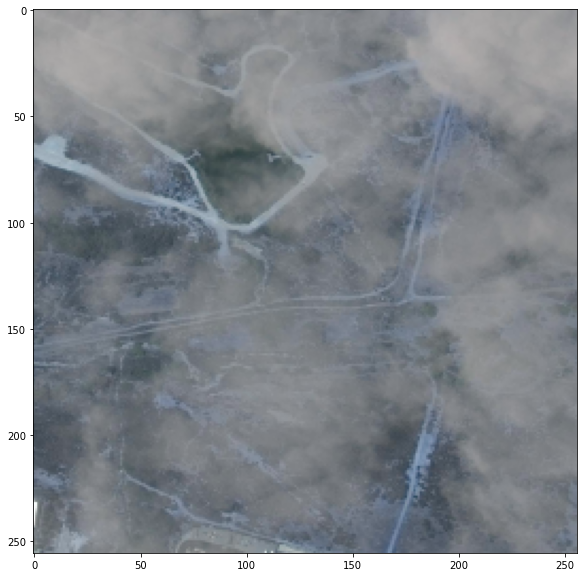

In [306]:
index = 239
plt.imshow(VAL_IMAGES[index])

64 64 190 0.9377350807189941


ValueError: zero-size array to reduction operation minimum which has no identity

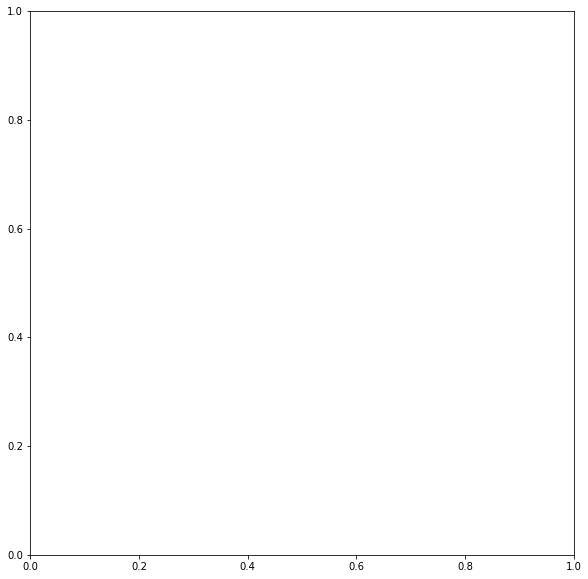

In [307]:
y = int(y_best[index])
x = int(x_best[index])
a = 360 - int(angles_best[index])
print(x, y , a, scores_all[index])
slicem = MATRIX_RESIZED[y-128:y+128, x-128:x+128]
slicer = ndimage.rotate(slicem, a)
plt.imshow(slicem)

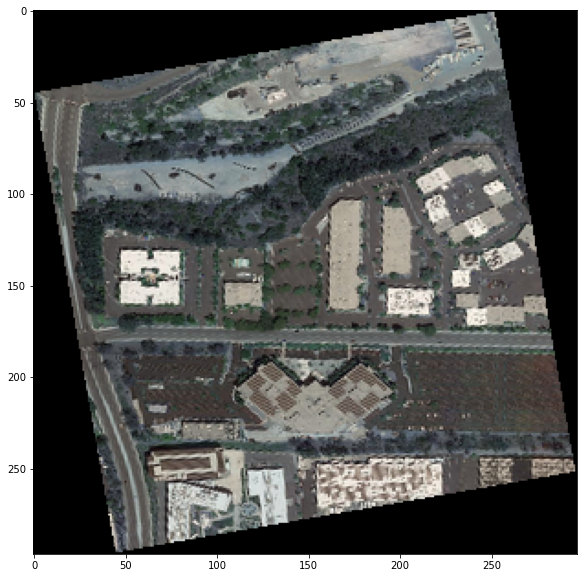

In [303]:
plt.imshow(ndimage.rotate(VAL_IMAGES[index], -a))

In [287]:
def rotate(origin, point, angle):
    angle = math.radians(angle)
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

In [288]:
left_top = rotate((x, y), (x - 128, y - 128), -a)
left_bottom = rotate((x, y), (x - 128, y + 128), -a)
right_bottom = rotate((x, y), (x + 128, y + 128), -a)
right_top = rotate((x, y), (x + 128, y - 128), -a)
print((x, y), a)
print(left_top, left_bottom, right_bottom, right_top)

(1720, 1072) 190
(1868.2823591269296, 1175.8284256441955) (1823.8284256441955, 923.7176408730703) (1571.7176408730704, 968.1715743558044) (1616.1715743558045, 1220.2823591269296)


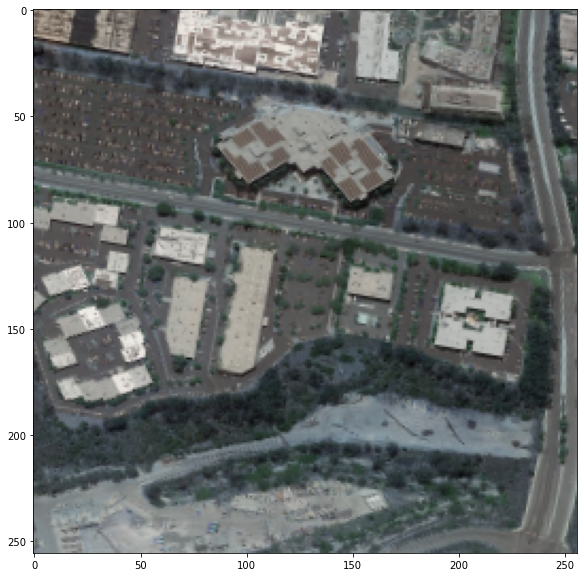

In [289]:
pt_A = left_top
pt_B = left_bottom
pt_C = right_bottom
pt_D = right_top

input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
output_pts = np.float32([[0, 0],
                        [0, 256],
                        [256, 256],
                        [256, 0],])

M = cv2.getPerspectiveTransform(input_pts,output_pts)
out = cv2.warpPerspective(MATRIX_RESIZED,M,(256, 256),flags=cv2.INTER_LINEAR)
plt.imshow(out)

In [300]:
SUBMIT_PATH = "/media/andrey/big/datasets/hacksAI/TaskMFTI/submit"
for index, name in enumerate(VAL_NAMES):
    number = name.split(".")[0]
    save_path = number + ".json"
    
    y = int(y_best[index]) * 4
    x = int(x_best[index]) * 4
    a = 360 - int(angles_best[index])
    
    
    if int(number) >= 803 or x <= 300 or y <=300:
        center = 10496 / 2
        offset = 512
        example_json = {}
        example_json["left_top"] = [center - offset, center - offset]
        example_json["left_bottom"] = [center - offset, center + offset]
        example_json["right_bottom"] = [center + offset, center + offset]
        example_json["right_top"]  = [center + offset, center - offset]
        example_json["angle"] = 180

        with open(os.path.join(SUBMIT_PATH, save_path), 'w') as outfile:
            json.dump(example_json, outfile)
    else:
        
        left_top = rotate((x, y), (x - 128, y - 128), -a)
        left_bottom = rotate((x, y), (x - 128, y + 128), -a)
        right_bottom = rotate((x, y), (x + 128, y + 128), -a)
        right_top = rotate((x, y), (x + 128, y - 128), -a)
        example_json = {}
        example_json["left_top"] = list(left_top)
        example_json["left_bottom"] = list(left_bottom)
        example_json["right_bottom"] = list(right_bottom)
        example_json["right_top"]  = list(right_top)
        example_json["angle"] = a
        print(example_json)
        with open(os.path.join(SUBMIT_PATH, save_path), 'w') as outfile:
            json.dump(example_json, outfile)

{'left_top': [9469.409803530745, 8183.8155893186], 'left_bottom': [9719.8155893186, 8130.590196469254], 'right_bottom': [9666.590196469255, 7880.1844106814], 'right_top': [9416.1844106814, 7933.409803530746], 'angle': 102}
{'left_top': [2379.2287447249596, 809.4738200471726], 'left_bottom': [2569.4738200471725, 980.7712552750403], 'right_bottom': [2740.7712552750404, 790.5261799528274], 'right_top': [2550.5261799528275, 619.2287447249597], 'angle': 48}
{'left_top': [3031.3829729274944, 5481.240630205991], 'left_bottom': [3049.2406302059903, 5736.617027072506], 'right_bottom': [3304.6170270725056, 5718.759369794009], 'right_top': [3286.7593697940097, 5463.382972927494], 'angle': 4}
{'left_top': [8500.92493184935, 7314.890348077463], 'left_bottom': [8274.890348077464, 7435.0750681506515], 'right_bottom': [8395.07506815065, 7661.109651922537], 'right_top': [8621.109651922536, 7540.9249318493485], 'angle': 298}
{'left_top': [5023.830586967779, 1643.0165694412417], 'left_bottom': [4779.0165

  0%|          | 0/524 [00:00<?, ?it/s]

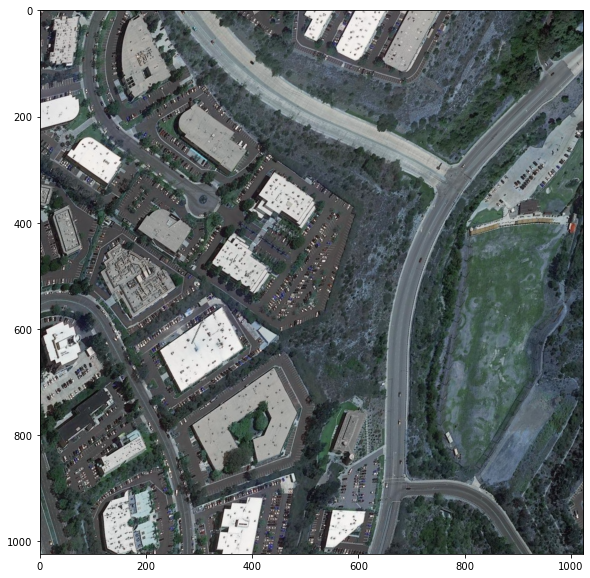

In [249]:
files = sorted(os.listdir(TRAIN_JSON_PATH), key=lambda x: int(x.split(".")[0]))
for name in tqdm(files[4:528]):
    with open(os.path.join(TRAIN_JSON_PATH, name)) as file:
        example_json = json.load(file)
    
    pt_A = example_json["left_top"]
    pt_B = example_json["left_bottom"]
    pt_C = example_json["right_bottom"]
    pt_D = example_json["right_top"]
    
    img = cv2.imread(os.path.join(TRAIN_IMG_PATH, name.split(".")[0] + ".png"))
    plt.imshow(img)
    
    input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
    output_pts = np.float32([[0, 0],
                            [0, 256],
                            [256, 256],
                            [256, 0]])

    M = cv2.getPerspectiveTransform(input_pts,output_pts)
    out = cv2.warpPerspective(matrix_bgr,M,(256, 256),flags=cv2.INTER_LINEAR)

    break

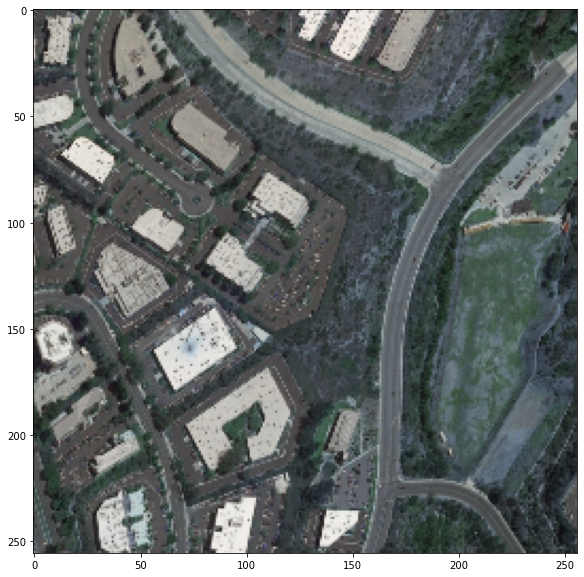

In [250]:
plt.imshow(out)